## Reguralization(Dropout, Normalization)
#### 1. Library
#### 2. Load Dataset and Preprocess
#### 3. MLP naive setting
#### 4. MLP batch norm
##### 4.1 with test phase
##### 4.2 with train, test phase
#### 5. Dropout
#### 6. Batch norm & Dropout

### 1. Library

In [0]:
import os
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.datasets import mnist as data
try: os.mkdir('MNIST')
except: pass

import warnings
warnings.filterwarnings(action = 'ignore')

### 2. Load Dataset and Preprocess

In [2]:
#load dataset
(x_train, y_train) , (x_test, y_test) = data.load_data()
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

train_n_sample = len(x_train)
shape = x_train[0].shape[0:]
n_class = len(np.unique(y_train))
print(train_n_sample, shape, n_class)

# reshape and normalization
X_train = x_train.reshape(-1, np.prod(shape)) / 255
X_test = x_test.reshape(-1, np.prod(shape)) / 255

# y onthot
Y_train = np.eye(n_class)[y_train.reshape(-1)]
Y_test = np.eye(n_class)[y_test.reshape(-1)]

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
60000 (28, 28) 10
(60000, 784) (10000, 784) (60000, 10) (10000, 10)


### 3. MLP naive setting

Hyperparameter setting

In [0]:
training_epochs = 100
learning_rate = 1e-1
display_step = 10

batch_size = 100

hidden_nodes = [1024, 300]
act = tf.nn.tanh
# 실수 방지하기 위해 hyperparameter 따로 설정하여 변경하기

Build FC Layer Model

In [0]:
# build 3-layer, fully-connected nearal network model
# hidden layers' size is [1024, 300]
tf.reset_default_graph()

# placeholder
tf_x = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_y = tf.placeholder(tf.float32, (None, n_class))

#model
hidden1 = tf.layers.dense(tf_x, 512, activation = act)
logit = tf.layers.dense(hidden1, n_class)
pred = tf.nn.softmax(logit)

# loss and optimziser
loss = tf.losses.softmax_cross_entropy(tf_y, pred)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [0]:
# train model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    epoch_losses, iter_losses = [], []
    total_batch = int(train_n_sample / batch_size)
    for epoch in range(training_epochs):
        #shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_x_train = X_train[random_idx]
        shuffled_y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            batch_x_train = shuffled_x_train[i * batch_size: (i+1)* batch_size]
            batch_y_train = shuffled_y_train[i * batch_size: (i+1) * batch_size]
            
            _, l = sess.run([optimizer, loss], feed_dict = {tf_x : batch_x_train, tf_y : batch_y_train})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if ((epoch) + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch + 1, epoch_losses[-1]))
            
    train_pred = sess.run(pred, feed_dict = {tf_x : X_train})
    test_pred = sess.run(pred, feed_dict = {tf_x : X_test})
    
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/naive_512/model')

Epoch: 10, 	 Loss: 1.5437594652175903
Epoch: 20, 	 Loss: 1.526613473892212
Epoch: 30, 	 Loss: 1.5149797201156616
Epoch: 40, 	 Loss: 1.50666344165802
Epoch: 50, 	 Loss: 1.5004653930664062
Epoch: 60, 	 Loss: 1.4957057237625122
Epoch: 70, 	 Loss: 1.4918454885482788
Epoch: 80, 	 Loss: 1.488653302192688
Epoch: 90, 	 Loss: 1.4859895706176758
Epoch: 100, 	 Loss: 1.483771800994873


In [0]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/naive_512/model.meta')
    saver.restore(sess, 'MNIST/naive_512/model')

W0822 21:32:55.623289 140601036445440 deprecation.py:323] From /home/pirl/anaconda3/envs/tens/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


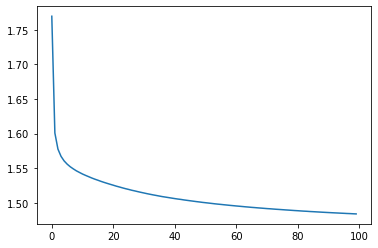

train accuracy 0.9816833333333334
test accuracy 0.9706
[[ 967    0    1    2    0    3    4    1    2    0]
 [   0 1121    2    2    0    1    4    2    3    0]
 [   5    1  997    4    6    1    5    5    8    0]
 [   0    0    6  984    0    4    1    8    5    2]
 [   1    0    5    0  959    1    4    1    3    8]
 [   7    0    0   10    1  859    7    1    4    3]
 [   7    2    1    1    2    8  931    1    5    0]
 [   1    8   15    1    4    1    0  989    1    8]
 [   3    1    2    7    3    4    5    7  940    2]
 [   5    5    3    9   10    4    1   10    3  959]]


In [0]:
#plot result
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
    
plot_epoch_losses(epoch_losses)

#accuracy
def print_accuracy(label, pred, name = ""):
    accuracy = np.mean(label == pred)
    print(name, 'accuracy', accuracy)
    
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis = 1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis = 1), 'test')

#confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis = 1))

Build FC Layer Model

In [0]:
tf.reset_default_graph()

tf_X = tf.placeholder(tf.float32, [None, np.prod(shape)])
tf_Y = tf.placeholder(tf.float32, [None, n_class])

#model
hidden1 = tf.layers.dense(tf_X, hidden_nodes[0], activation = act)
hidden2 = tf.layers.dense(hidden1, hidden_nodes[1], activation = act)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [0]:
# train and save model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    total_batch = int(train_n_sample / batch_size)
    epoch_losses, iter_losses = [], []
    for epoch in range(training_epochs):
        #shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_x = X_train[random_idx]
        shuffled_y = Y_train[random_idx]
        
        for i in range(total_batch):
            batch_x_train = shuffled_x[i * batch_size: (i+1) * batch_size]
            batch_y_train = shuffled_y[i * batch_size: (i+1) * batch_size]
            
            _, l = sess.run([optimizer, loss], feed_dict = {tf_X : batch_x_train, tf_Y : batch_y_train})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[- total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \tLoss: {}'.format(epoch + 1, epoch_losses[-1]))
            
        train_pred = sess.run(pred, feed_dict = {tf_X : X_train})
        test_pred = sess.run(pred, feed_dict = {tf_X : X_test})
        
        saver = tf.train.Saver()
        saver.save(sess, 'MNIST/naive_1024-300/model')

Epoch: 10, 	Loss: 0.05753568559885025
Epoch: 20, 	Loss: 0.021235212683677673
Epoch: 30, 	Loss: 0.009505270048975945
Epoch: 40, 	Loss: 0.0052546048536896706
Epoch: 50, 	Loss: 0.0033778357319533825
Epoch: 60, 	Loss: 0.0023991845082491636
Epoch: 70, 	Loss: 0.0018364846473559737
Epoch: 80, 	Loss: 0.0014820341020822525
Epoch: 90, 	Loss: 0.0012293874751776457
Epoch: 100, 	Loss: 0.0010482820216566324


In [0]:
# Load model
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/naive_1024-300/model.meta')
    saver.restore(sess, 'MNIST/naive_1024-300/model')
    saver.save(sess, 'MNIST/naive_1024-300_/model')

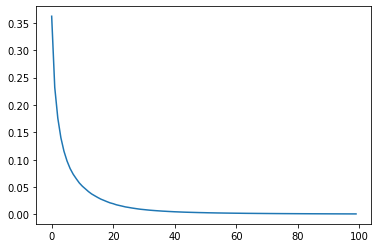

train  accuracy:  1.0
test  accuracy:  0.9834
[[ 974    0    1    0    1    0    1    1    2    0]
 [   0 1128    1    2    0    1    1    1    1    0]
 [   4    1 1012    3    1    0    2    4    5    0]
 [   0    1    2  993    0    3    0    3    3    5]
 [   1    0    1    1  963    1    4    1    0   10]
 [   3    1    0    7    1  872    4    1    1    2]
 [   3    1    1    1    4    6  942    0    0    0]
 [   2    2    6    1    1    1    0 1010    0    5]
 [   3    0    3    4    4    5    0    3  950    2]
 [   1    3    0    5    5    1    0    3    1  990]]


In [0]:
# plot epoch losses
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
plot_epoch_losses(epoch_losses)

# accuracy
def print_accuracy(label, pred, name):
    accuracy = np.mean(label==pred)
    print(name, ' accuracy: ', accuracy)
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')

# confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))

Build FC Layer Model (show inner distribution)

In [5]:
# build 3-layer fully-connected neural network model
# hidden layers' size is [1024, 300]
tf.reset_default_graph()

tf_X = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_Y = tf.placeholder(tf.float32, (None, n_class))

output1 = tf.layers.dense(tf_X, hidden_nodes[0])
hidden1 = tf.nn.tanh(output1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
hidden2 = tf.nn.tanh(output2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

W0824 07:43:02.135828 139739600648064 deprecation.py:323] From <ipython-input-5-87459e753fab>:6: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0824 07:43:02.142308 139739600648064 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0824 07:43:02.503334 139739600648064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    epoch_losses, iter_losses = [], []
    total_batch = int(train_n_sample / batch_size)
    for epoch in range(training_epochs):
        #shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_x_train = X_train[random_idx]
        shuffled_y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            batch_x_train = shuffled_x_train[i * batch_size : (i+1) * batch_size]
            batch_y_train = shuffled_y_train[i * batch_size : (i+1) * batch_size]
            
            _, l = sess.run([optimizer, loss], feed_dict = {tf_X : batch_x_train, tf_Y : batch_y_train})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \tLoss: {}'.format(epoch + 1, epoch_losses[-1]))
            
    train_pred = sess.run(pred, feed_dict = {tf_X : X_train})
    test_pred = sess.run(pred, feed_dict = {tf_X : X_test})
    
    #save
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/naive_1024-300/model')

Epoch: 10, 	Loss: 0.05790324509143829
Epoch: 20, 	Loss: 0.02234676107764244
Epoch: 30, 	Loss: 0.010166659019887447
Epoch: 40, 	Loss: 0.005426327232271433
Epoch: 50, 	Loss: 0.003401033114641905
Epoch: 60, 	Loss: 0.0024168076924979687
Epoch: 70, 	Loss: 0.0018443341832607985
Epoch: 80, 	Loss: 0.0014770989073440433
Epoch: 90, 	Loss: 0.0012274448527023196
Epoch: 100, 	Loss: 0.0010414450662210584


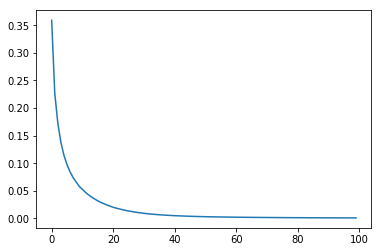

train accuracy 1.0
test accuracy 0.9817
[[ 974    0    1    1    1    1    0    1    1    0]
 [   0 1125    1    2    0    1    2    1    3    0]
 [   5    1 1009    3    1    0    2    5    6    0]
 [   0    0    4  990    0    5    0    3    3    5]
 [   1    0    0    1  963    1    5    1    0   10]
 [   4    0    0    4    1  873    4    0    4    2]
 [   5    2    1    1    2    5  940    0    2    0]
 [   2    1    8    2    2    0    0 1005    3    5]
 [   3    0    3    4    3    3    1    3  952    2]
 [   1    2    0    3   11    1    0    3    2  986]]


In [7]:
#plot result
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
    
plot_epoch_losses(epoch_losses)

#accuracy
def print_accuracy(label, pred, name = ""):
    accuracy = np.mean(label == pred)
    print(name, 'accuracy', accuracy)
    
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis = 1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis = 1), 'test')

#confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis = 1))

W0824 07:50:02.077354 139739600648064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


(10000, 784) (10000, 1024) (10000, 1024) (10000, 300) (10000, 300)


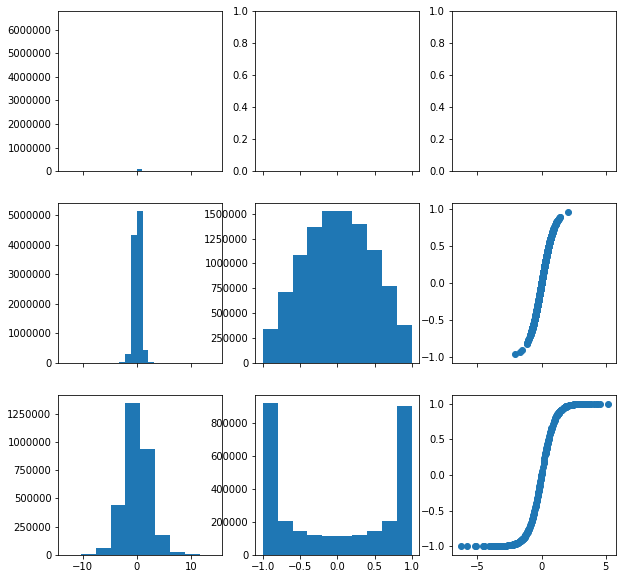

In [8]:
# show inner distribution
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/naive_1024-300/model.meta')
    saver.restore(sess, 'MNIST/naive_1024-300/model')
    #print(X_test.shape)
    [x, o1, h1, o2, h2] = sess.run([tf_X, output1, hidden1, output2, hidden2], 
                                   feed_dict = {tf_X : X_test})
    print(x.shape, o1.shape, h1.shape, o2.shape, h2.shape)
    
def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(3,3, figsize = (10,10), sharex = 'col')
    axs[0,0].hist(x.reshape(-1))
    axs[1,0].hist(o1.reshape(-1))
    axs[1,1].hist(h1.reshape(-1))
    axs[1,2].scatter(o1[0], h1[0])
    axs[2,0].hist(o2.reshape(-1))
    axs[2,1].hist(h2.reshape(-1))
    axs[2,2].scatter(o2[0], h2[0])
    plt.show()
plot_inner_dist(x, o1, h1, o2, h2)

### 4. MLP batch norm

In [14]:
tf.reset_default_graph()

tf_X = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_Y = tf.placeholder(tf.float32, (None, n_class))

output1 = tf.layers.dense(tf_X, hidden_nodes[0])
norm1 = tf.contrib.layers.batch_norm(output1)
hidden1 = act(norm1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
norm2 = tf.contrib.layers.batch_norm(output2)
hidden2 = act(norm2)
logit = tf.layers.dense(hidden2, n_class)
pred = act(logit)

loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

W0823 06:24:27.041934 140054928144256 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### 4.1 with test phase

In [0]:
tf.reset_default_graph()

tf_X = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_Y = tf.placeholder(tf.float32, (None, n_class))

output1 = tf.layers.dense(tf_X, hidden_nodes[0])
norm1 = tf.contrib.layers.batch_norm(output1, is_training = False)
hidden1 = act(norm1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
norm2 = tf.contrib.layers.batch_norm(output2, is_training = False)
hidden2 = act(norm2)
logit = tf.layers.dense(hidden2, n_class)
pred = act(logit)

loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [16]:
#train model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    epoch_losses, iter_losses = [], []
    total_batch = int(train_n_sample / batch_size)
    for epoch in range(training_epochs):
        #shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_x_train = X_train[random_idx]
        shuffled_y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            batch_x_train = shuffled_x_train[i * batch_size : (i+1) * batch_size]
            batch_y_train = shuffled_y_train[i * batch_size : (i+1) * batch_size]
            
            _, l = sess.run([optimizer, loss], feed_dict = {tf_X : batch_x_train, tf_Y : batch_y_train})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \tLoss: {}'.format(epoch + 1, epoch_losses[-1]))
            
    train_pred = sess.run(pred, feed_dict = {tf_X : X_train})
    test_pred = sess.run(pred, feed_dict = {tf_X : X_test})
    
    #save
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/batch_norm_off_1024-300/model')

Epoch: 10, 	Loss: 0.059432290494441986
Epoch: 20, 	Loss: 0.022350164130330086
Epoch: 30, 	Loss: 0.010059577412903309
Epoch: 40, 	Loss: 0.005408041644841433
Epoch: 50, 	Loss: 0.0034353986848145723
Epoch: 60, 	Loss: 0.002462417585775256
Epoch: 70, 	Loss: 0.0018798065138980746
Epoch: 80, 	Loss: 0.00151476776227355
Epoch: 90, 	Loss: 0.0012567988596856594
Epoch: 100, 	Loss: 0.0010668131290003657


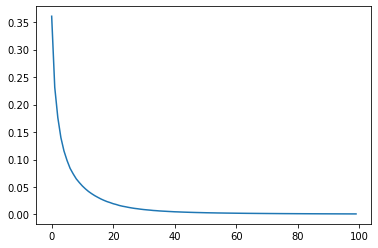

train accuracy 0.9614
test accuracy 0.9406
[[ 974    0    1    2    1    1    0    0    0    1]
 [   0 1128    2    0    0    1    2    1    1    0]
 [   7   21  990    3    1    0    1    4    5    0]
 [   0    1   11  987    0    1    0    1    3    6]
 [   1    1    4    1  968    0    1    2    0    4]
 [   3    2    0   96    1  785    4    0    0    1]
 [  10    2    2    1   19   37  886    0    1    0]
 [   3    6   22   39    7    0    0  941    3    7]
 [   4    0   10   33    4   19    8    5  888    3]
 [   3    6    0   20   49   13    0   46   13  859]]


In [0]:
#plot result
plot_epoch_losses(epoch_losses)
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis = 1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis = 1), 'test')
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis = 1))

(10000, 784) (10000, 1024) (10000, 1024) (10000, 300) (10000, 300)


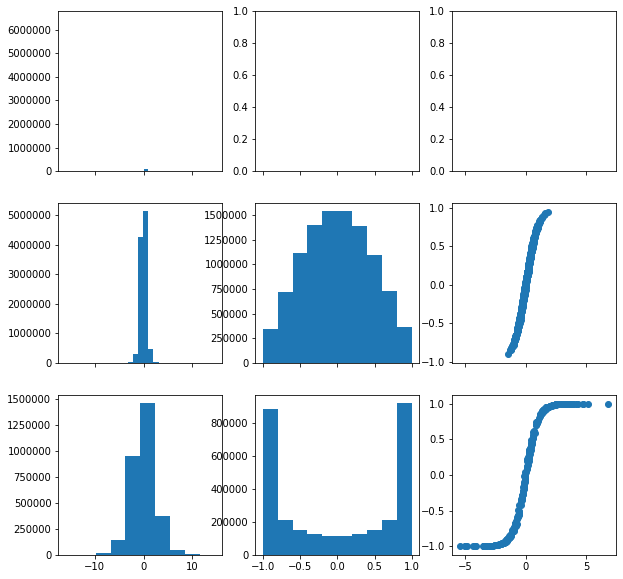

In [0]:
# show inner distribution
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/batch_norm_off_1024-300/model.meta')
    saver.restore(sess, 'MNIST/batch_norm_off_1024-300/model')

    [x, o1, h1, o2, h2] = sess.run(
        [tf_X, output1, hidden1, output2, hidden2], 
        feed_dict={tf_X: X_test})
    print(x.shape, o1.shape, h1.shape, o2.shape, h2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex='col')
    axs[0, 0].hist(x.reshape(-1))
    axs[1, 0].hist(o1.reshape(-1))
    axs[1, 1].hist(h1.reshape(-1))
    axs[1, 2].scatter(o1[0], h1[0])
    axs[2, 0].hist(o2.reshape(-1))
    axs[2, 1].hist(h2.reshape(-1))
    axs[2, 2].scatter(o2[0], h2[0])
    plt.show()
plot_inner_dist(x, o1, h1, o2, h2)

#### 4.2 with train, test phase

In [9]:
tf.reset_default_graph()

tf_X = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_Y = tf.placeholder(tf.float32, (None, n_class))
is_train = tf.placeholder(tf.bool, [])

output1 = tf.layers.dense(tf_X, hidden_nodes[0])
norm1 = tf.contrib.layers.batch_norm(output1, is_training = is_train)
hidden1 = act(norm1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
norm2 = tf.contrib.layers.batch_norm(output2, is_training = is_train)
hidden2 = act(norm2)
logit = tf.layers.dense(hidden2, n_class)
pred = act(logit)

loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

W0824 07:51:08.307715 139739600648064 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    epoch_losses, iter_losses = [], []
    total_batch = int(train_n_sample / batch_size)
    for epoch in range(training_epochs):
        #shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_x_train = X_train[random_idx]
        shuffled_y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            batch_x_train = shuffled_x_train[i * batch_size : (i+1) * batch_size]
            batch_y_train = shuffled_y_train[i * batch_size : (i+1) * batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X : batch_x_train, tf_Y : batch_y_train, is_train : True})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \tLoss: {}'.format(epoch + 1, epoch_losses[-1]))
            
    train_pred = sess.run(pred, feed_dict = {tf_X : X_train, is_train :False})
    test_pred = sess.run(pred, feed_dict = {tf_X : X_test, is_train :False})
    
    #save
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/batch_norm_1024-300/model')

Epoch: 10, 	Loss: 0.013220773078501225
Epoch: 20, 	Loss: 0.0016714994562789798
Epoch: 30, 	Loss: 0.0009224148816429079
Epoch: 40, 	Loss: 0.0034690166357904673
Epoch: 50, 	Loss: 0.00042659390601329505
Epoch: 60, 	Loss: 0.00024167244555428624
Epoch: 70, 	Loss: 0.00017685082275420427
Epoch: 80, 	Loss: 0.00016846692597027868
Epoch: 90, 	Loss: 0.00012919334403704852
Epoch: 100, 	Loss: 0.00010592746548354626


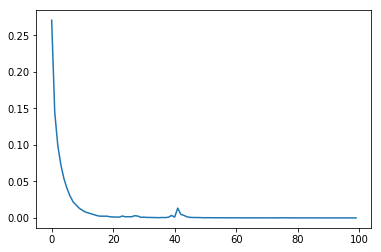

train accuracy 0.9962666666666666
test accuracy 0.9717
[[ 974    1    1    1    0    1    0    1    1    0]
 [   0 1128    2    0    0    1    2    1    1    0]
 [   7    7 1002    4    1    0    2    6    3    0]
 [   0    0   18  980    0    4    0    3    4    1]
 [   1    0    0    1  970    0    3    2    2    3]
 [   3    0    0   34    1  848    3    1    1    1]
 [   3    2    3    0    8   11  930    0    1    0]
 [   0    7    8    5    3    2    0  997    2    4]
 [   2    0    5    9    3   12    3    4  934    2]
 [   3    3    1   10   14    3    0   12    9  954]]


In [11]:
#plot result
plot_epoch_losses(epoch_losses)
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis = 1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis = 1), 'test')
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis = 1))

(10000, 784) (10000, 1024) (10000, 1024) (10000, 300) (10000, 300)


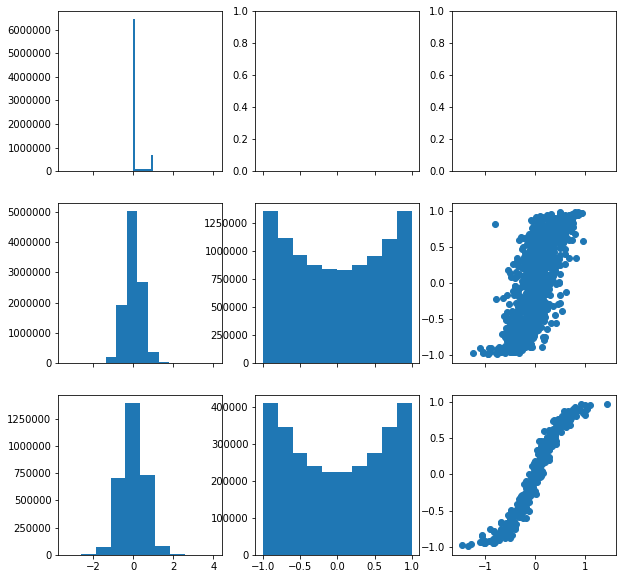

In [12]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/batch_norm_1024-300/model.meta')
    saver.restore(sess, 'MNIST/batch_norm_1024-300/model')

    [x, o1, h1, o2, h2] = sess.run(
        [tf_X, output1, hidden1, output2, hidden2], 
        feed_dict={tf_X: X_test, is_train:False})
    print(x.shape, o1.shape, h1.shape, o2.shape, h2.shape)

plot_inner_dist(x, o1, h1, o2, h2)

### 5. Dropout

In [0]:
#hyperparameter setting
training_epochs = 200
learning_rate = 1e-1
display_step = 10

batch_size = 100

hidden_nodes = [1024, 300]
act = tf.nn.tanh
dropout_rate = .2

In [7]:
tf.reset_default_graph()

# placeholder
tf_X = tf.placeholder(tf.float32, [None, np.prod(shape)])
tf_Y = tf.placeholder(tf.float32, [None, n_class])
is_train = tf.placeholder(tf.bool, [])

# model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
dropout1 = tf.contrib.layers.dropout(output1, keep_prob=1.-dropout_rate, is_training=is_train)
hidden1 = act(dropout1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
dropout2 = tf.contrib.layers.dropout(output2, keep_prob=1.-dropout_rate, is_training=is_train)
hidden2 = act(dropout2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

# loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

W0824 13:30:38.237657 139669984925568 deprecation.py:323] From <ipython-input-7-7d4c7aaacfe3>:9: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0824 13:30:38.246103 139669984925568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0824 13:30:39.570427 139669984925568 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    epoch_losses, iter_losses = [], []
    total_batch = int(train_n_sample / batch_size)
    for epoch in range(training_epochs):
        #shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_x_train = X_train[random_idx]
        shuffled_y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            batch_x_train = shuffled_x_train[i * batch_size : (i+1) * batch_size]
            batch_y_train = shuffled_y_train[i * batch_size : (i+1) * batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X : batch_x_train, tf_Y : batch_y_train, is_train : True})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \tLoss: {}'.format(epoch + 1, epoch_losses[-1]))
            
    train_pred = sess.run(pred, feed_dict = {tf_X : X_train, is_train:False})
    test_pred = sess.run(pred, feed_dict = {tf_X : X_test, is_train:False})
    
    #save
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/dropout_1024-300/model')

Epoch: 10, 	Loss: 0.09099826216697693
Epoch: 20, 	Loss: 0.052310436964035034
Epoch: 30, 	Loss: 0.035099372267723083
Epoch: 40, 	Loss: 0.02673635445535183
Epoch: 50, 	Loss: 0.018948810175061226
Epoch: 60, 	Loss: 0.015273462980985641
Epoch: 70, 	Loss: 0.01228091586381197
Epoch: 80, 	Loss: 0.010230954736471176
Epoch: 90, 	Loss: 0.009938625618815422
Epoch: 100, 	Loss: 0.007595492992550135
Epoch: 110, 	Loss: 0.006976763252168894
Epoch: 120, 	Loss: 0.0057731205597519875
Epoch: 130, 	Loss: 0.0062321824952960014
Epoch: 140, 	Loss: 0.005379037000238895
Epoch: 150, 	Loss: 0.00465019466355443
Epoch: 160, 	Loss: 0.004302655812352896
Epoch: 170, 	Loss: 0.0037755905650556087
Epoch: 180, 	Loss: 0.00364104937762022
Epoch: 190, 	Loss: 0.0037903960328549147
Epoch: 200, 	Loss: 0.003552814247086644


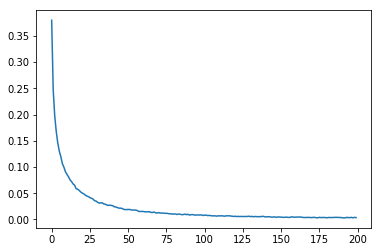

train accuracy 1.0
test accuracy 0.984
[[ 973    0    2    0    0    0    1    1    2    1]
 [   0 1124    3    1    0    1    2    1    3    0]
 [   2    1 1014    2    1    0    3    3    6    0]
 [   0    0    1 1000    0    2    0    1    4    2]
 [   0    0    2    1  966    0    4    0    0    9]
 [   4    0    0    8    0  871    4    1    3    1]
 [   3    2    1    1    2    2  944    0    3    0]
 [   2    1    6    3    0    0    0 1009    4    3]
 [   2    0    3    4    2    3    1    1  956    2]
 [   2    2    0    4    9    1    0    6    2  983]]


In [9]:
#plot result
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
    
plot_epoch_losses(epoch_losses)

#accuracy
def print_accuracy(label, pred, name = ""):
    accuracy = np.mean(label == pred)
    print(name, 'accuracy', accuracy)
    
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis = 1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis = 1), 'test')

#confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis = 1))

### 6. Batch norm & Dropout

In [0]:
#plot result
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
    
plot_epoch_losses(epoch_losses)

#accuracy
def print_accuracy(label, pred, name = ""):
    accuracy = np.mean(label == pred)
    print(name, 'accuracy', accuracy)
    
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis = 1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis = 1), 'test')

#confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis = 1))#hyperparameter setting
training_epochs = 150
learning_rate = 1e-1
display_step = 10

batch_size = 100

hidden_nodes = [1024, 300]
act = tf.nn.tanh
dropout_rate = .2

In [0]:
tf.reset_default_graph()

# placeholder
tf_X = tf.placeholder(tf.float32, [None, np.prod(shape)])
tf_Y = tf.placeholder(tf.float32, [None, n_class])
is_train = tf.placeholder(tf.bool, [])

# model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
norm1 = tf.contrib.layers.batch_norm(output1)
dropout1 = tf.contrib.layers.dropout(norm1, keep_prob=1.-dropout_rate, is_training=is_train)
hidden1 = act(dropout1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
norm2 = tf.contrib.layers.batch_norm(output2)
dropout2 = tf.contrib.layers.dropout(norm2, keep_prob=1.-dropout_rate, is_training=is_train)
hidden2 = act(dropout2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

# loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [7]:
with tf.Session() as sess:
    # init
    sess.run(tf.global_variables_initializer())
    
    # train
    epoch_losses, iter_losses = [], []
    total_batch = int( train_n_sample / batch_size )
    for epoch in range(training_epochs):
        # shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            # get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train, is_train:True})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))
    
    # result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train, is_train:False})
    test_pred = sess.run(pred, feed_dict = {tf_X:X_test, is_train:False})
    
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/batch_norm-dropout_1024-300/model')

Epoch: 10, 	 Loss: 0.05274080112576485
Epoch: 20, 	 Loss: 0.026752877980470657
Epoch: 30, 	 Loss: 0.01567045785486698
Epoch: 40, 	 Loss: 0.013530537486076355
Epoch: 50, 	 Loss: 0.00946507602930069
Epoch: 60, 	 Loss: 0.008099592290818691
Epoch: 70, 	 Loss: 0.006690133363008499
Epoch: 80, 	 Loss: 0.005837511271238327
Epoch: 90, 	 Loss: 0.006047409493476152
Epoch: 100, 	 Loss: 0.005397706758230925
Epoch: 110, 	 Loss: 0.0043333894573152065
Epoch: 120, 	 Loss: 0.004373412579298019
Epoch: 130, 	 Loss: 0.003997943364083767
Epoch: 140, 	 Loss: 0.0036798000801354647
Epoch: 150, 	 Loss: 0.003168475115671754


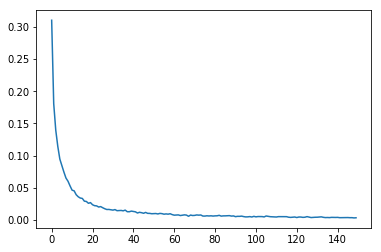

train accuracy 1.0
test accuracy 0.9805
[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1124    4    1    0    0    2    1    3    0]
 [   6    2 1007    4    2    0    2    4    4    1]
 [   0    0    2  994    0    8    0    3    2    1]
 [   0    0    1    1  967    0    4    0    0    9]
 [   2    0    0    7    1  872    5    1    3    1]
 [   3    2    2    0    4    4  943    0    0    0]
 [   1    2    8    5    0    1    0 1000    2    9]
 [   5    1    1    4    5    4    1    4  946    3]
 [   5    3    0    6    8    3    0    4    2  978]]


In [8]:
#plot result
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
    
plot_epoch_losses(epoch_losses)

#accuracy
def print_accuracy(label, pred, name = ""):
    accuracy = np.mean(label == pred)
    print(name, 'accuracy', accuracy)
    
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis = 1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis = 1), 'test')

#confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis = 1))